In [110]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [111]:
import numpy as np
import pandas as pd

In [112]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [113]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [114]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [115]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [116]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [117]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [118]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [119]:
#view columns in database as pandas df
pd.read_sql_query('select * from measurement', con=engine).head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [120]:
#Find the most recent date
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#convert the most recent date to datetime object. Calculate the date 1 year ago for the start date. 
recent_dt = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')
start_dt = recent_dt - dt.timedelta(365)


start_dt

datetime.datetime(2016, 8, 23, 0, 0)

In [121]:
# Query the last 12 months of data and include date and prcp
precip_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(start_dt, recent_dt)).all()

# Save the query results as a Pandas DataFrame 
precip_df = pd.DataFrame(precip_year, columns=["date", "prcp"])

#sort by date
precip_df = precip_df.sort_values('date')

#set index to date column
precip_df = precip_df.set_index('date')

precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


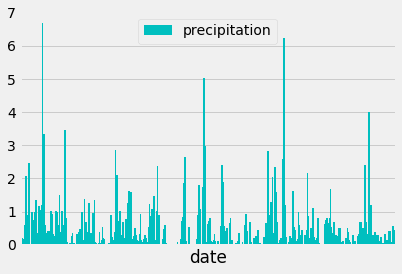

In [122]:
#plot a bar graph of precipitation over the year
ax = precip_df.plot.bar( color = 'c', width = 10)
plt.xticks([])
plt.legend(['precipitation'])
plt.show()

In [123]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [124]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).count()

9

In [125]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

#save the most active variable to a variable
most_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).first()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [126]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active[0]).\
order_by((Measurement.tobs).desc()).first()

lowest_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active[0]).\
order_by((Measurement.tobs).asc()).first()

avg_temp = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
filter(Measurement.station == most_active[0]).first()

lowest_temp[0], highest_temp[0], avg_temp[0]

(54.0, 85.0, 71.66378066378067)

In [127]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).first()

# Query the last 12 months of data for the station with the most temp data
temp_active_year = session.query(Measurement.tobs).\
filter(and_(Measurement.date.between(start_dt, recent_dt),Measurement.station == temp_active[0] )).all()

#Convert the query to a dataframe
temp_df = pd.DataFrame(temp_active_year, columns=["tobs"])

temp_df = temp_df.reset_index(drop=True)

temp_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


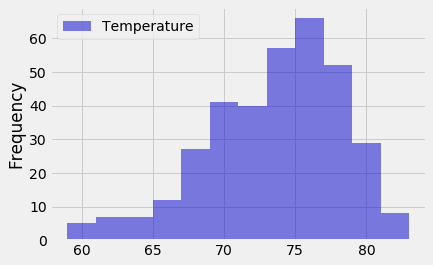

In [128]:
#Create histogram of last years temperatures of the station with the most temperature observations
x = temp_df["tobs"].values.tolist()
bins = 12
n, bins, patches = plt.hist(x, bins, facecolor='mediumblue', alpha=0.5)
plt.legend(['Temperature'])
plt.ylabel('Frequency')
plt.show()

In [129]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [130]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_stats = calc_temps('2011-02-28', '2011-03-05')

trip_stats

[(61.0, 69.75510204081633, 75.0)]

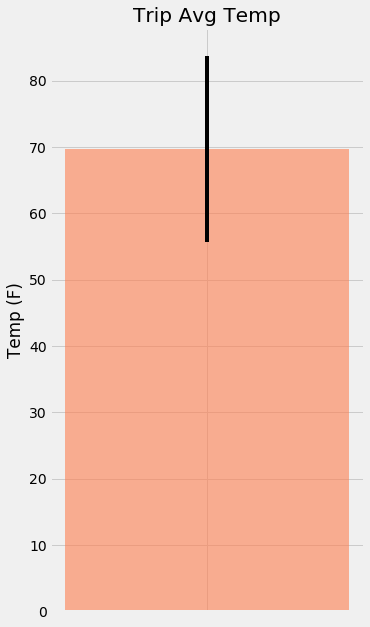

In [131]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = trip_stats[0][1]
x = [""]
error = trip_stats[0][2] - trip_stats[0][0]
plt.figure(figsize=(5,10))
plt.bar(x,y,color = 'coral', yerr=error, alpha=0.6)
plt.ylabel('Temp (F)')
plt.title("Trip Avg Temp")
plt.show()

In [139]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
group_by(Station.name).filter(Station.station == Measurement.station ).\
filter(Measurement.date.between('2011-02-28', '2011-03-05')).order_by(func.sum(Measurement.prcp).desc()).all()


[('UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.33),
 ('WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.23),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.19),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.96),
 ('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.45),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.63),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]